# Multilayer Perceptron Classifier in Numpy from Scratch

In this notebook, I will implement a Neural Network from scratch using the Numpy library. The exact type of Neural Network we will build is a Multilayer Perceptron, also known as a Feedforward Neural Network. This is a densely connected Neural Network, that was described in detail in previous articles. Our Neural Network will be designed to handle classification problems involving datasets with 3 predictor input features, and a single binary output.

Let's start by importing the necessary packages we will need into this notebook:

In [1]:
# imports
from typing import List, Tuple
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

Now we can create our implementation. The Neural Network we will build will tackle classification problems, and will be encapsulated in a single class called **MLP351Classifier**. The following simplifying assumptions will be made for this model:

1) The sigmoid activation function will be used for all hidden and output neurons
2) The cross-entropy loss function, described in a previous article (https://insidelearningmachines.com/cross_entropy_loss/), will be used during training
3) I'm fixing the Neural Network to have an input layer with 3 neurons, a single hidden layer with 5 neurons, and an output layer with 1 neuron

## Model Implementation

In [2]:
class MLP351Classifier(object):
    """
    Class to encapsulate a Multilayer Perceptron / FeedForward Neural Network classifier
    """
    
    def __init__(self, lr: float=1e-2, epoches: int=100) -> None:
        """
        Initialiser function for a class instance
        
        Inputs:
            lr      -> learning rate
            epoches -> number of epoches to use during training
        """
        self.lr      = lr
        self.epoches = epoches
        self.layers  = [3,5,1]
        self.weights = []
        self.biases  = []
        self.loss    = []
        
    def __del__(self) -> None:
        """
        Destructor function for a class instance
        """
        del self.lr
        del self.epoches
        del self.layers
        del self.weights
        del self.biases
        del self.loss
        
    def _loss(self, y_true: np.array, y_pred: np.array) -> np.array:
        """
        Function to compute cross-entropy loss per sample
        
        Inputs:
            y_true -> numpy array of true labels
            y_pred -> numpy array of prediction values
        Output:
            loss value
        """
        return -y_true*np.log2(y_pred) - (1 - y_true)*np.log2(1 - y_pred)
    
    def _derivative_loss(self, y_true: np.array, y_pred: np.array) -> np.array:
        """
        Function to compute the derivative of the cross-entropy loss per sample
        
        Inputs:
            y_true -> numpy array of true labels
            y_pred -> numpy array of prediction values
        Output:
            loss value
        """
        return -(1/np.log(2))*( (y_true/y_pred) - ((1-y_true)/(1-y_pred)) )
    
    def _sigmoid(self, z: np.array) -> np.array:
        """
        Function to compute sigmoid activation function
        
        Input:
            z -> input dot product w*x + b
        Output:
            determined activation
        """
        return 1/(1+np.exp(-z))
    
    def _derivative_sigmoid(self, z: np.array) -> np.array:
        """
        Function to compute the derivative of the sigmoid activation function
        
        Input:
            z -> input dot product w*x + b
        Output:
            determined derivative of activation
        """
        return self._sigmoid(z)*(1 - self._sigmoid(z))
    
    def _forward_pass(self, X: np.array) -> Tuple[List[np.array], List[np.array]]:
        """
        Function to perform forward pass through the network
        
        Input:
            X -> numpy array of input predictive features with assumed shape [number_features, number_samples]
        Output:
            list of activations & derivatives for each layer
        """ 
        # record from input layer
        input_to_layer = np.copy(X)
        activations    = [input_to_layer]
        derivatives    = [np.zeros(X.shape)]
        
        # hidden layer
        z_i = np.matmul(self.weights[0],input_to_layer) + self.biases[0]
        input_to_layer = self._sigmoid(z_i)
        activations.append(input_to_layer)
        derivatives.append(self._derivative_sigmoid(z_i))
        
        # output layer
        z_i = np.matmul(self.weights[1],input_to_layer) + self.biases[1]
        input_to_layer = self._sigmoid(z_i)
        activations.append(input_to_layer)
        derivatives.append(self._derivative_sigmoid(z_i))
        
        # return results
        return(activations, derivatives)
    
    def _backward_pass(self, 
                       activations: List[np.array], 
                       derivatives: List[np.array], 
                       y: np.array) -> Tuple[List[np.array], List[np.array]]:
        """
        Function to perform backward pass through the network
        
        Inputs:
            activations -> list of activations from each layer in the network
            derivatives -> list of derivatives from each layer in the network
            y           -> numpy array of target values 
                           with assumed shape [number_samples, output dimension]
        Output:
            list of numpy arrays containing the derivates of the loss function wrt layer weights
        """ 
        # record loss
        self.loss.append((1/y.shape[1])*np.sum(self._loss(y, activations[-1])))
        
        # output layer
        dl_dy2 = self._derivative_loss(y, activations[2])
        dl_dz2 = np.multiply(dl_dy2, derivatives[2])
        dl_dw2 = (1/y.shape[1])*np.matmul(dl_dz2, activations[1].T)
        dl_db2 = (1/y.shape[1])*np.sum(dl_dz2, axis=1)
        
        # hidden layer
        dl_dy1 = np.matmul(self.weights[1].T, dl_dz2)
        dl_dz1 = np.multiply(dl_dy1, derivatives[1])
        dl_dw1 = (1/y.shape[1])*np.matmul(dl_dz1, activations[0].T)
        dl_db1 = (1/y.shape[1])*np.sum(dl_dz1, axis=1)
        
        # return derivatives
        return([dl_dw1, dl_dw2], [dl_db1, dl_db2])
    
    def _update_weights(self, dl_dw: List[np.array], dl_db: List[np.array]) -> None:
        """
        Function to apply update rule to model weights
        
        Input:
            dl_dw -> list of numpy arrays containing loss derivatives wrt weights
        """
        self.weights[0] -= self.lr*dl_dw[0]
        self.weights[1] -= self.lr*dl_dw[1]
        self.biases[0]  -= self.lr*dl_db[0].reshape(-1,1)
        self.biases[1]  -= self.lr*dl_db[1].reshape(-1,1)
        
    def fit(self, X: np.array, y: np.array) -> None:
        """
        Function to train a class instance
        
        Inputs:
            X -> numpy array of input predictive features with assumed shape [number_samples, number_features]
            y -> numpy array of target values with assumed shape [number_samples, output dimension]
        """
        # initialise the model parameters
        self.weights.clear()
        self.biases.clear()
        self.loss.clear() 
        for idx in range(len(self.layers)-1):
            self.weights.append(np.random.randn(self.layers[idx+1], self.layers[idx]) * 0.1)
            self.biases.append(np.random.randn(self.layers[idx+1], 1) * 0.1)         
        # loop through each epoch
        for _ in range(self.epoches):
            # do forward pass through the network
            activations, derivatives = self._forward_pass(X.T)
            # do backward pass through the network
            dl_dw, dl_db = self._backward_pass(activations, derivatives, y.T)
            # update weights
            self._update_weights(dl_dw, dl_db)   
            
    def predict(self, X: np.array) -> np.array:
        """
        Function to produce predictions from a trained class instance
        
        Input:
            X -> numpy array of input predictive features with assumed shape [number_samples, number_features]
        Output:
            numpy array of model predictions
        """
        # do forward pass through the network
        activations, _ = self._forward_pass(X.T)
        # return predictions
        return np.rint(activations[2]).reshape(-1)

## Create Dataset

Let's produce a dataset with 10000 samples, consisting of 3 predictive input features, of which 2 are informative and the remainder is redundant. The target will consist of a single binary output:

In [3]:
# generate a dataset
X,y = make_classification(n_samples=10000, n_features=3, n_informative=2, n_redundant=1, random_state=42)

We can produce some box plots to get a sense of the distribution in the input predictive features:

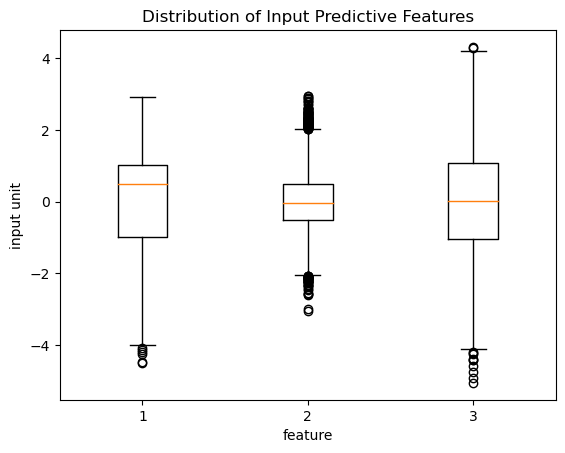

In [4]:
plt.boxplot(X)
plt.title("Distribution of Input Predictive Features")
plt.xlabel("feature")
plt.ylabel("input unit")
plt.show()

... and a histogram of the true labels:

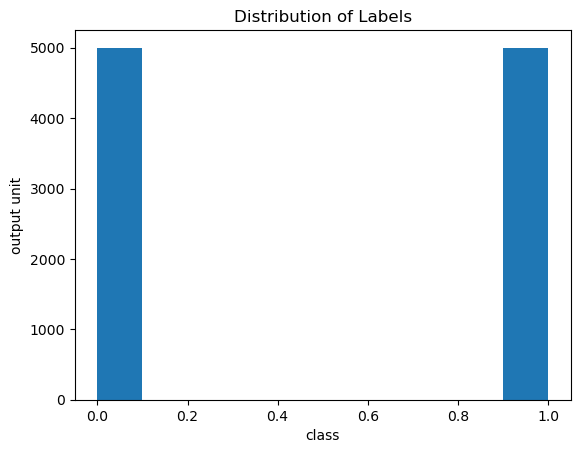

In [5]:
plt.hist(y)
plt.title("Distribution of Labels")
plt.xlabel("class")
plt.ylabel("output unit")
plt.show()

The input features 2 & 3 appear to be approximately zero-centered, whereas feature 1 as a median that is clearly a positive value. The range for each feature varies, with the narrowest range belonging to feature 2 $(-2,+2)$ and the broadest with feature 3 $(-4,+4)$. Outliers are present for each feature, with the largest concentration being with feature 2.

The true labels $(0$ and $1)$ are roughly evenly split in these data.

Finally, we can do a train-test split, with 80% of the data being allocated for training:

In [6]:
# perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Test Model

Now let's create an instance of our implemented class, and train it on the training data. I'll use a learning rate of 1.0, and we'll train for 2000 epochs:

In [11]:
# train the classifier
model = MLP351Classifier(lr=1.0,epoches=2000)
model.fit(X_train,y_train.reshape(-1,1))

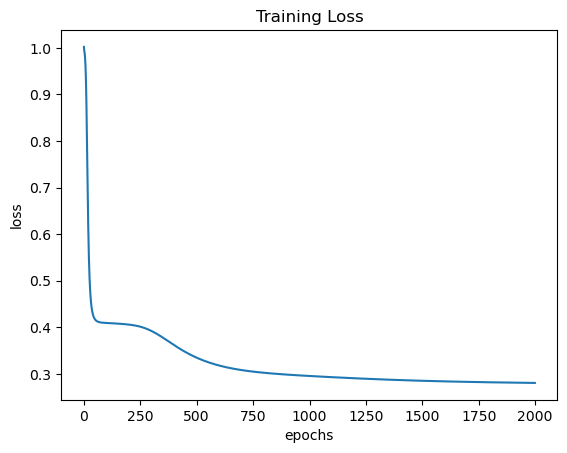

In [12]:
# plot the training loss
plt.plot(model.loss)
plt.title("Training Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Plotting the training loss shows a rapid decline at first, followed by a gradual decline for ~500 epochs. The loss then gentily slopes down from epoch 500 to 2000. This shows that our training procedure is working. Now let's evaluate how well our classifier performs in making predictions:

In [13]:
# generate predictions
y_pred = model.predict(X_test)

In [14]:
# evaluate model performance
print(f"accuracy: {accuracy_score(y_test, y_pred):.2f} and F1 score: {f1_score(y_test, y_pred):.2f}")

accuracy: 0.93 and F1 score: 0.93


The accuracy and F1 results indicates that our classifier functions reasonably well on the test data provided. 